# Practical work on the Conversion of sampling frequency and STFT


*From MICHAUD Jules and MENDIHARAT Titouan*

**python version : 3.9**

In [2]:
import os
import sys
import wave
import struct

import numpy as np
#import pyaudio
#import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write
from IPython.display import Audio


## Functions

In [31]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk=1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk)

    stream.stop_stream()
    stream.close()
    p.terminate()


def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()


## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [32]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename)


### **Using wave**

In [33]:
wavefile = load_sound(sound)
print(wavefile.getparams())


_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [34]:
play = False
if play:
    play_sound(sound)


In [35]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)


In [36]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep


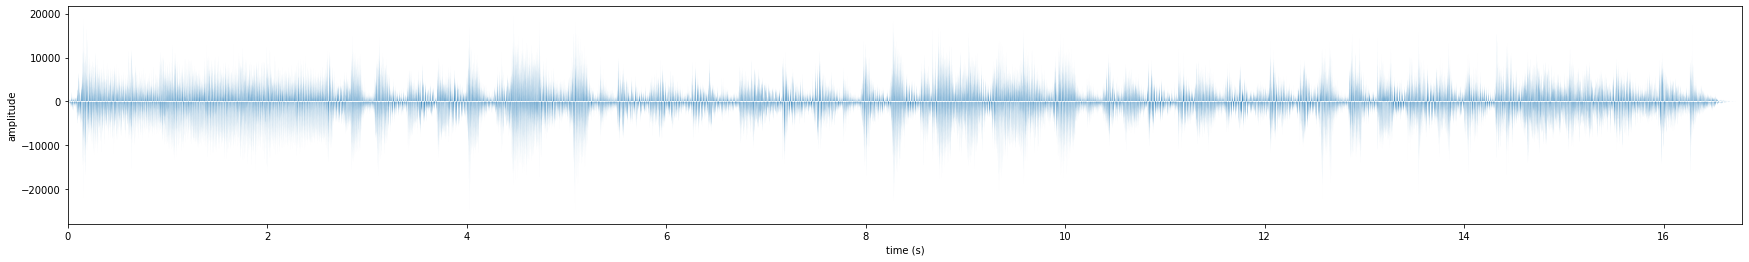

In [37]:
plot_sound(x, times)


In [38]:
# to write a new wave file
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16))


## Signal analysis with the STFT

In [ ]:
N = x.shape[0]  # % longueur du signal
Nw = 512
w = np.hanning(Nw)  # définition de la fenetre d'analyse
ws = w.copy  # définition de la fenêtre de synthèse
R = Nw/4  # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512  # ordre de la tfd
L = M/2+1
affich = 1  # pour affichage du spectrogramme, 0 pour
# pour faire analyse/modif/synthèse sans affichage
# note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R)  # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N, 1))  # signal de synthèse

if affich:
    Xtilde = np.zeros((M, Nt), dtype=complex)


In [40]:
for u in np.arange(0, Nt).reshape(-1):  # boucle sur les trames
    deb = u * R + 1  # début de trame
    fin = deb + Nw  # fin de trame
    # calcul de la trame
    tx = np.multiply(x[np.arange(deb.astype(int), fin.astype(int))], w)
    X = np.fft.fft(tx, M)  # tfd à l'instant b
    if affich:
        Xtilde[:, u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add


def extents(f):
    delta = f[1] - f[0]
    return [f[0] - delta/2, f[-1] + delta/2]


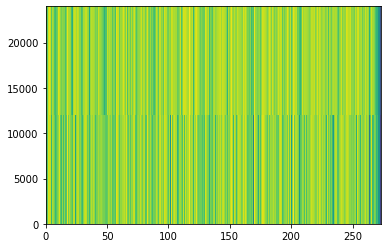

In [48]:
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0, L), :])), aspect='auto', interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])


## Overlap-add reconstruction

In [9]:
def ola(w=None, hop=None, Nb=10):
    # function output = ola(w,hop,Nb)
    # realise l'addition-recouvrement de la fenetre w,
    # avec un décalage hop et un nombre Nb de fenetres.
    # par defaut Nb = 10;

    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N, 1))  # réserve l'espace memoire

    for k in np.arange(0, Nb).reshape(-1):
        deb = k * hop
        fin = deb + N
        output[np.arange(deb, fin)] = output[np.arange(deb, fin)] + w  # OLA

    return output


## 1 - Conversion of sampling rate

#### Question 1

In [49]:
M = 3
L = 2
nu_c = 1.0/(2*3)

h = signal.remez(102, [0, nu_c, nu_c + 1.0/50, 0.5], [L, 0])
W, Hf = signal.freqz(h, [1], worN=len(h))
H = np.abs(np.fft.fft(h))
dB = 20 * np.log10(H)


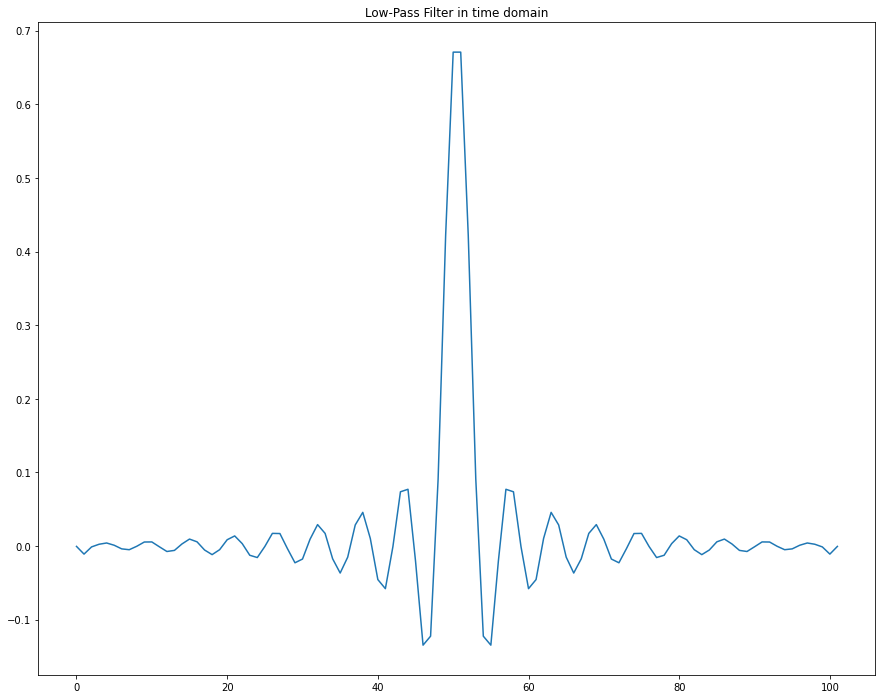

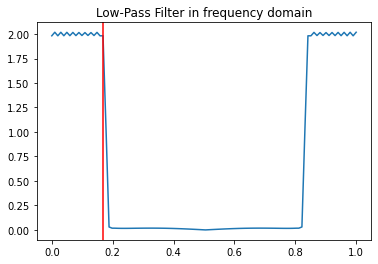

/var/folders/n2/_45gp9c50lg2c479spn_1td40000gn/T/ipykernel_2894/194634606.py:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,0.5)


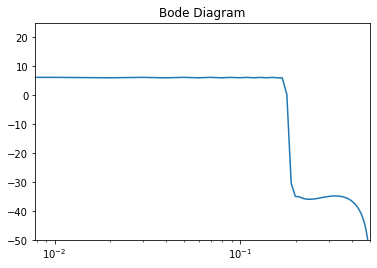

In [50]:
plt.figure(figsize=(15, 12))
plt.plot(h)
plt.title('Low-Pass Filter in time domain')
plt.show()

plt.plot(np.linspace(0, 1, len(H)), H)
plt.axvline(nu_c, color='red')
plt.title('Low-Pass Filter in frequency domain')
plt.show()

plt.semilogx(np.linspace(0, 1, len(H)), dB)
plt.xlim(0, 0.5)
plt.ylim(-50, 25)
plt.title('Bode Diagram')
plt.show()


#### Question 2


We must first upsample the original signal by L (=2) and then downsample it by M (=3) for the conversion of sampling rate. To do so, we create an upsampling and a downsampling function to apply on our data.

In [52]:
def upsampling(data, L):
    data_upsampled = np.zeros((len(data)*L)-(L-1))
    data_upsampled[0:len(data_upsampled):L] = data
    return data_upsampled


def downsampling(data, M):
    data_downsampled = data[0:len(data):M]
    return data_downsampled


With our new functions, we just take the signal, apply the upsampling function, then apply our low-pass filter, and finally apply the downsampling function to achieve the conversion. Finally, we will play the result.

In [68]:
%%time
#total: 55.5 ms

x_upsampled = upsampling(x, L)
y_method_1_upsampled = np.convolve(x_upsampled, h)
y_method_1 = downsampling(y, M)

CPU times: user 41.2 ms, sys: 12 ms, total: 53.2 ms
Wall time: 127 ms


In [67]:
write('caravan_32kHz_method_1.wav', 32000, np.array(y_method_1, dtype=np.int16))
Audio(y_method_1, rate=32000)

#### Question 3


First of all, we have to determine our filters R0 and R1 and then E00, E01, E02, E10, E11 and E12

In [54]:
r_selection = np.arange(h.shape[0]//2)*2
r_0 = h[r_selection]
r_2 = h[r_selection + 1]

e_selection = (np.arange(r_0.shape[0]//3))*3
e_00 = r_0[e_selection]
e_01 = r_0[e_selection + 1]
e_02 = r_0[e_selection + 2]

e_10 = r_2[e_selection]
e_11 = r_2[e_selection + 1]
e_12 = r_2[e_selection + 2]

Then, we only need to create a delay function because we already created an upsampling and a downsampling ones. 

In [55]:
def delay(x,a):
  x = np.concatenate((np.zeros(a),x),axis = None)
  return x

Finally, we apply two successive polyphase decompositions with our new filters and delay function and we play the result to compare.


In [65]:
%%time
#total: 30.9 ms

x1 = np.append(delay(x,1),0)
x2 = delay(x1,1)

aux = x.copy()
aux = np.append(aux,0)
aux = np.append(aux,0)

sum_e_0 = np.convolve(e_00,downsampling(aux,3)) + np.convolve(e_01,downsampling(x1,3)) + np.convolve(e_02,downsampling(x2,3))
sum_e_1 = np.convolve(e_10,downsampling(aux,3)) + np.convolve(e_11,downsampling(x1,3)) + np.convolve(e_12,downsampling(x2,3))

y_method_2 = np.insert(upsampling(sum_e_0,2),0,0) + np.append(upsampling(sum_e_1,2),0)

CPU times: user 16.1 ms, sys: 14.8 ms, total: 30.9 ms
Wall time: 49.8 ms


In [66]:
write('caravan_32kHz_method_2.wav', 32000, np.array(y_method_2, dtype=np.int16))
Audio(y_method_2, rate=32000)

As expected, the result is the same as with the first method.

#### Question 4

We added in the previous question a time calcul (thanks to the %%time method). As we can see, the first method ended in 55.5 ms and the second one ended in 30.9 ms.

The second method is indeed faster than the first one, but a little less than expected, because we expected a factor $(L*M)^2 = 36$ between the two methods.

This is due to the fact that the calculations in our implementation are not done in parallel but in sequence. 

## 2 - STFT audio equalization

#### Question 1

Let's plot the Hann window both in time and frequency domain

c:\Users\titou\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


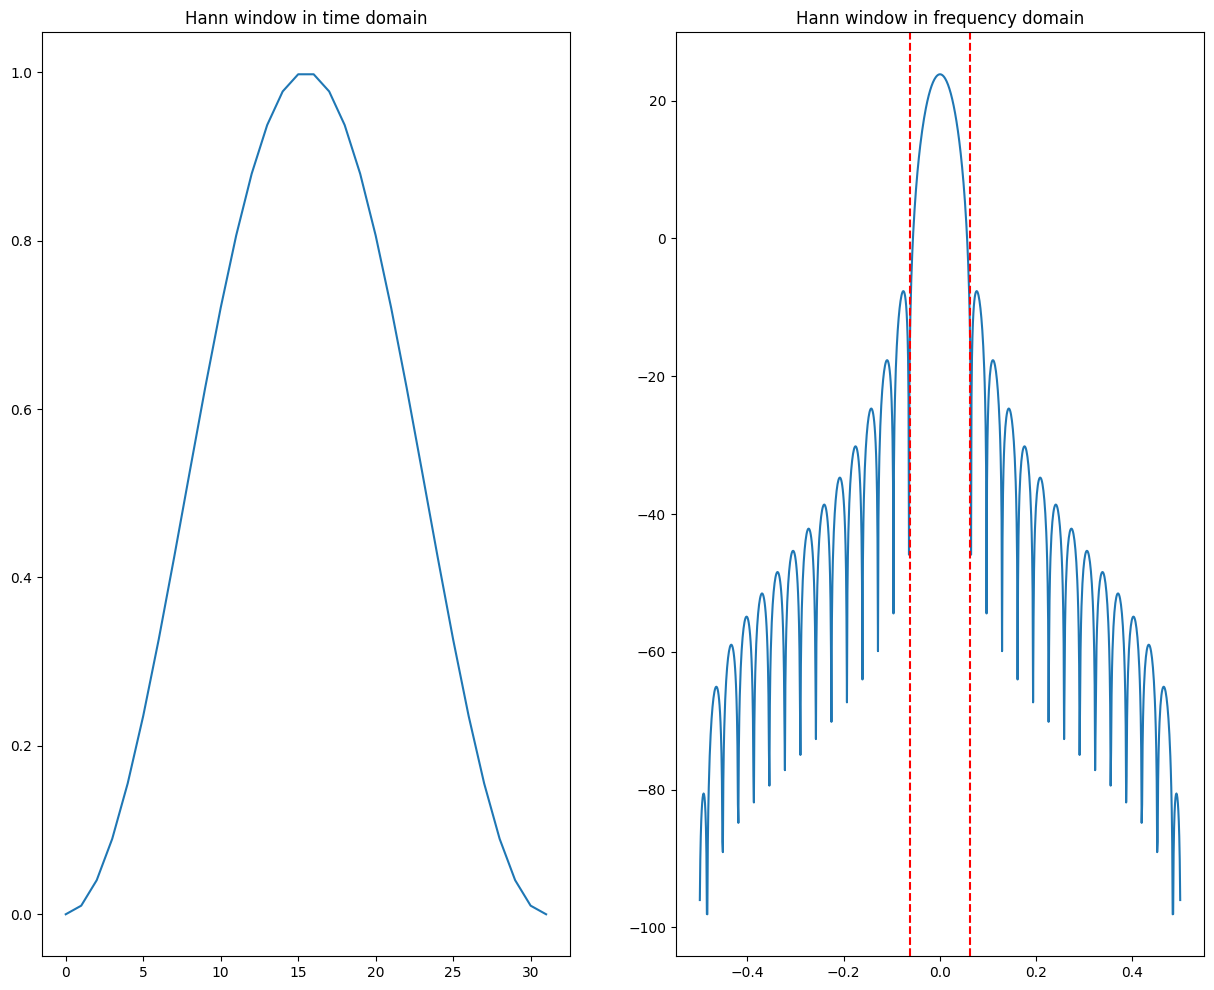

In [7]:
Nw = 32
w = np.hanning(Nw) # définition de la fenetre d'analyse
M = 1024 # ordre de la tfd

plt.figure(figsize=(15,12))

# Hann Window - time
plt.subplot(1, 2, 1) 
plt.plot(w)
plt.title('Hann window in time domain')

# Hann Window - frequency
fw = np.fft.fft(w,M)
freq = np.linspace(-0.5, 0.5, len(fw))
amp = 20 * np.log10(abs(np.fft.fftshift(fw)))
plt.subplot(1, 2, 2)
plt.plot(freq,amp)
plt.title('Hann window in frequency domain')
plt.axvline(-2.0/Nw,color = 'red', linestyle = '--')
plt.axvline(2.0/Nw,color = 'red', linestyle = '--')
plt.show()

#### Question 2

Given the expression of the STFT in the notebook template, we can tell that it corresponds to the band-pass convention.

$\tilde{X}(k,u) = \sum_{n}{x(n + uR)w(n)e^{-j2\pi\frac{kn}{M}}}$

#### Question 3

Let's compute the signal $x_k = \tilde{X}(k,u)$ for k = 3, M = 32 and R = 1 using the band-pass convention.

In [ ]:
print(Xtilde[3,:])

As we can tell by the list obtained, $x_k(u)$ is a complex signal for k = 3.

We know that the we can express $\tilde{X}(k,u)$ as  $\tilde{X}(k,u) = (h*x)(u)$, where $h(n) = w(-n)e^{2\pi\frac{kn}{M}}$, which is a band-pass of center frequency $\frac{k}{M} = \frac{3}{32}$ and bandwidth $\frac{4}{N_w} = \frac{4}{32}$.

Using a Remez filter, we can then get $\tilde{X}$.

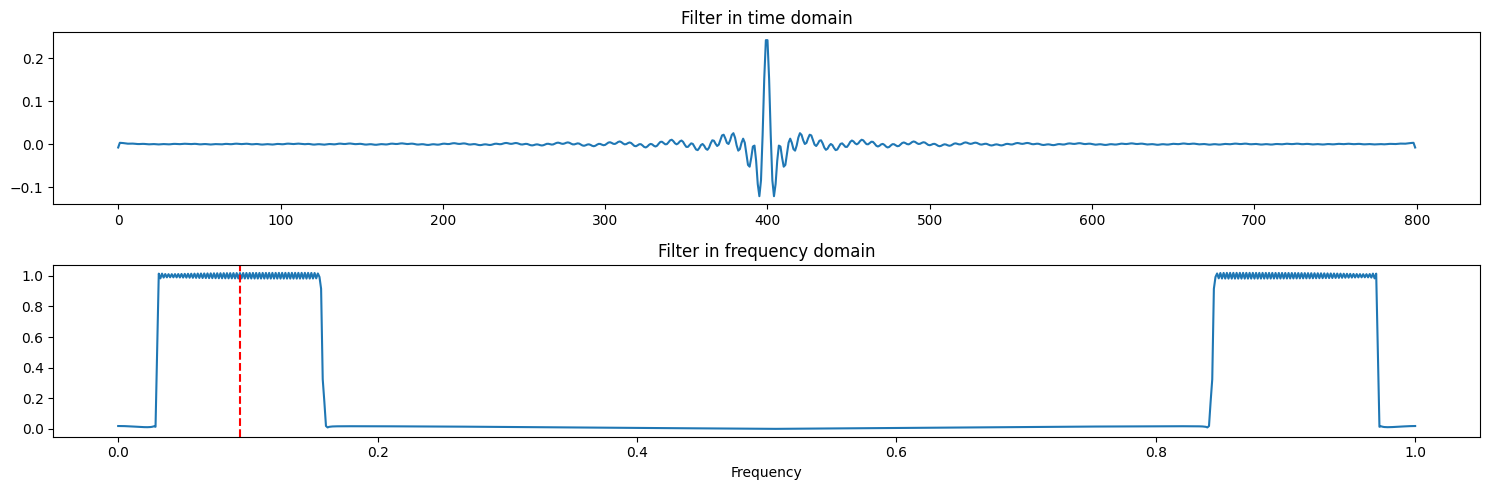

In [5]:
h=signal.remez(800,[0,0.029,0.031,0.156,0.16,.5],[0,1,0])
H = np.abs(np.fft.fft(h))

plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(h)
plt.title('Filter in time domain')
plt.subplot(2,1,2)
plt.plot(np.linspace(0,1,len(H)),H)
plt.axvline(3.0/32,color = 'red',linestyle = '--')
plt.title('Filter in frequency domain')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

#### Question 4

In [ ]:
x3 = np.convolve(h,x)

f_Xtilde, t_Xtilde, Sxx_Xtilde = signal.spectrogram(np.real(Xtilde[3,:]),Fs,w,32)
f_x3, t_x3, Sxx_x3 = signal.spectrogram(np.real(x3),Fs,w,32)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.pcolormesh(t_Xtilde, f_Xtilde, 20*np.log10(Sxx_Xtilde), shading='auto')
plt.title(r'Spectogram of $\tilde{X}$ using the algorithm implementation')
plt.subplot(2,1,2)
plt.pcolormesh(t_x3, f_x3, 20*np.log10(Sxx_x3), shading='auto')
plt.title(r"Spectogram of $\tilde{X}$ using the filtering process")
plt.show()

It is noticed that the process that uses a remez bandpass filter generates a spectrogram very similar to that obtained by the algorithm that was provided for this work. In addition, we can also compare the audio generated by the two different processes.


In [ ]:
Audio(np.real(Xtilde[3,:]), rate=Fs)

In [ ]:
Audio(np.real(x3), rate=Fs)

#### Question 5

Since $f(n) = \sum_{u\in\mathbb{Z}}^{} w(n-uR)w_s(n-uR)$, we have to check if f(n)=1 $\forall n$ is a perfect reconstruction condition for the product window $w_{p}(n) = w(n)w_{s}(n) = h(n)^{2}$, where h(n) is a Hann window correctly normalized, and for a 75% overlap.

For that, first we apply our hann window without normalizing it in the function to obtain the maximum value in the output. Knowing this value, we use its square root to normalize the window. We observe that the output is not exactly 1 from the beginning to the ending, because $N_{b}$ is finite. Therefore, we will have an almost perfect reconstruction.

Text(0.5, 1.0, 'Non normalised version')

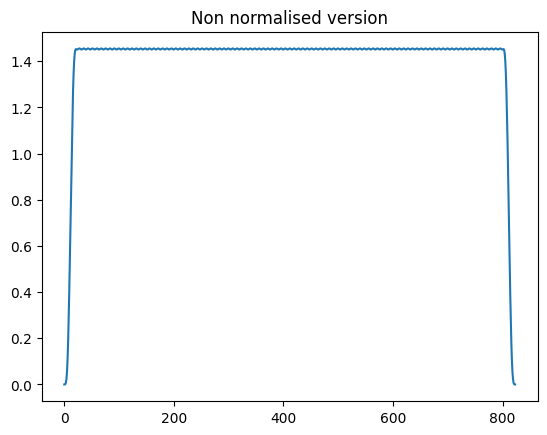

In [10]:
h=np.multiply(w,w)
f=ola(h,int(0.25*len(w)),100)
plt.plot(np.arange(0,len(f)),f)
plt.title("Non normalised version")

Text(0.5, 1.0, 'Normalised version')

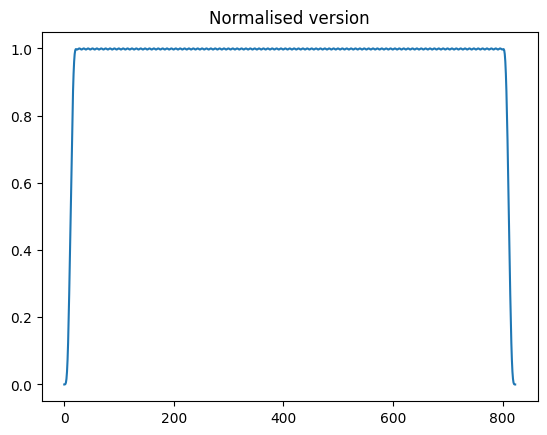

In [11]:
h=np.multiply(w/np.sqrt(np.amax(f)),w/np.sqrt(np.amax(f)))
f=ola(h,int(0.25*len(w)),100)
plt.plot(np.arange(0,len(f)),f)
plt.title("Normalised version")

FInally, we want to implement the resynthesis according to the
overlap-add approach. In the end, we were able to check the validity of perfect reconstruction by hearing the audio signal and by ploting it through time.

In [ ]:
y=np.zeros(len(w),dtype=complex)

for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 
    fin = deb + Nw 
    tx=np.fft.ifft(Xtilde[:,u],M)
    y[deb.astype(int):fin.astype(int)]=y[deb.astype(int):fin.astype(int)]+np.multiply(tx,w/np.amax(f))
plt.plot(y)
plt.plot("Resynthesis")

In [ ]:
Audio(y, rate=Fs)

#### Question 6

In this final section, we're going to equalize the signal. Using a  $\frac{M}{2} + 1 $ real channel, we will assign weights to each channel. So that we can adjust (atenuate or amplificate) each frequency as we want to.

In [12]:
def equalizer(x,weight,k):
  y = x.copy()
  j = 0
  for i in k:
    y[i,:] =  x[i,:]*weight[j]
    j+=1
  return y

In [ ]:
weights = 0.1*np.ones(M/2+1)
k = np.array(range(17,32))
Xtilde = equalizer(Xtilde,weights,k)
y=np.zeros(N,dtype=complex)
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 
    fin = deb + Nw 
    tx=np.fft.ifft(Xtilde[:,u],M)
    y[deb.astype(int):fin.astype(int)]=y[deb.astype(int):fin.astype(int)]+np.multiply(tx,w/np.amax(f))
plt.plot(y)


In [ ]:
Audio(y, rate=Fs)